In [1]:
from md4.configs.hollow_md4.text8 import get_config
from collections.abc import Callable, Mapping, Sequence
import copy
import functools
from typing import Any

from absl import logging
from clu import metric_writers
from clu import metrics
from clu import parameter_overview
from clu import periodic_actions
from etils import epath
import flax
import flax.jax_utils as flax_utils
import flax.linen as nn
import grain.python as grain
import jax
from jax.experimental import checkify
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
from orbax import checkpoint as orbax_checkpoint

from md4 import input_pipeline
from md4 import input_pipeline_v2
from md4 import sampling
from md4 import utils
from md4.models import utils as model_utils

from md4.train import *
from md4.train import _get_checkpoint_manager

import pickle
from tqdm import tqdm

config = get_config()
workdir = "/root/md4/expt_contantlr_deeper__model_untie"

2025-04-05 00:06:59.093029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743811619.106782   77118 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743811619.111218   77118 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743811619.123983   77118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743811619.123997   77118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743811619.123999   77118 computation_placer.cc:177] computation placer alr

cv2 not found


In [2]:
workdir = epath.Path(workdir)
workdir.mkdir(parents=True, exist_ok=True)

rng = utils.get_rng(config.seed)
logging.info("Using random seed %s.", rng)
writer = metric_writers.create_default_writer(
    workdir, just_logging=jax.process_index() > 0
)

# Learning rate schedule.
assert config.batch_size % jax.device_count() == 0
per_device_batch_size = config.batch_size // jax.device_count()
num_train_steps = input_pipeline.get_num_train_steps(config)
steps_per_epoch = num_train_steps // config.num_epochs
logging.info("num_train_steps=%d, steps_per_epoch=%d", num_train_steps, steps_per_epoch)
schedule_fn = functools.partial(
    get_learning_rate,
    base_learning_rate=config.learning_rate,
    num_steps=num_train_steps,
    warmup_steps=config.warmup_steps,
    schedule_type=config.learning_rate_schedule,
)

# Build input pipeline.
rng, data_seed = jax.random.split(rng)
data_seed = int(
    jax.random.randint(data_seed, [], minval=0, maxval=np.iinfo(np.int32).max)
)
# The input pipeline runs on each process and loads data for local TPUs.
create_datasets = (
    input_pipeline_v2.create_datasets
    if config.get("use_v2_input_pipeline", None)
    else input_pipeline.create_datasets
)
train_loader, eval_loaders, dataset_info = create_datasets(config, data_seed)

train_iter = iter(train_loader)

# Initialize model.
rng, model_rng = jax.random.split(rng)
data_shape = input_pipeline.get_data_shape(config)
# Note: parameters are initialized in half precision if mixed_precision_training=True
# We could also try casting them to half precision here
model, optimizer, train_state, metrics_class = (
    create_train_state(  # pylint: disable=invalid-name
        config,
        model_rng,
        input_shape=(per_device_batch_size // config.num_microbatches,) + data_shape,
        schedule_fn=schedule_fn,
    )
)

# Set up checkpointing of the model and the input pipeline.
checkpoint_manager = _get_checkpoint_manager(config, workdir)

# Retrieve data from previous checkpoints if possible.
checkpointed_state = dict(train_state=train_state, train_iter=train_iter)
if checkpoint_manager.latest_step() is not None:
    checkpointed_state = checkpoint_manager.restore(
        checkpoint_manager.latest_step(), items=checkpointed_state
    )
train_state = checkpointed_state["train_state"]
train_iter = checkpointed_state["train_iter"]

I0000 00:00:1743811645.244714   77118 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 92886 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:03:00.0, compute capability: 9.0
I0000 00:00:1743811645.246891   77118 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 92898 MB memory:  -> device: 1, name: NVIDIA H100 NVL, pci bus id: 0000:04:00.0, compute capability: 9.0
I0000 00:00:1743811645.248851   77118 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 92898 MB memory:  -> device: 2, name: NVIDIA H100 NVL, pci bus id: 0000:63:00.0, compute capability: 9.0
I0000 00:00:1743811645.251388   77118 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 92898 MB memory:  -> device: 3, name: NVIDIA H100 NVL, pci bus id: 0000:64:00.0, compute capability: 9.0
I0000 00:00:1743811645.253282   77118 gpu_device.cc:2019] Created device /job:localhost/

In [3]:
# Distribute training.
train_state = flax_utils.replicate(train_state)
train_step_func = functools.partial(
    train_step,
    model=model,
    optimizer=optimizer,
    train_metrics_class=metrics_class,
    learning_rate_fn=schedule_fn,
    ema_rate=config.ema_rate,
    num_microbatches=config.get("num_microbatches", None),
)
if config.check_nans:
    train_step_func = checkify.checkify(train_step_func, errors=checkify.float_checks)
p_train_step = jax.pmap(train_step_func, axis_name="batch", donate_argnums=(0,))
p_eval_step = jax.pmap(
    functools.partial(
        eval_step,
        model=model,
        eval_metrics_class=metrics_class,
        ema_rate=config.ema_rate,
    ),
    axis_name="batch",
)

hooks = []
report_progress = periodic_actions.ReportProgress(
    num_train_steps=num_train_steps, writer=writer
)
if jax.process_index() == 0:
    hooks += [
        report_progress,
        periodic_actions.Profile(num_profile_steps=5, logdir=workdir),
    ]
train_metrics = None

# Unreplicating from TPU is costly, so we only do it once at the start.
initial_step = int(flax.jax_utils.unreplicate(train_state.step))

In [4]:
batch = utils.reshape_batch(next(train_iter))

if config.check_nans:
    errs, (train_state, metrics_update) = p_train_step(
        train_state=train_state, batch=batch
    )
    errs.throw()
else:
    train_state, metrics_update = p_train_step(train_state=train_state, batch=batch)
metric_update = flax_utils.unreplicate(metrics_update)

train_metrics = (
    metric_update if train_metrics is None else train_metrics.merge(metric_update)
)

2025-04-04 23:27:35.897089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743809255.910521   49398 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743809255.914822   49398 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743809255.926160   49398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743809255.926178   49398 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743809255.926180   49398 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
batch_size 64
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


In [4]:
results_dict = {}

for timesteps in tqdm([16, 32, 64, 128, 256]):
    model.timesteps = timesteps
    # with report_progress.timed("sample"):
    _, sample_rng = jax.random.split(rng)
    dummy_loader = train_loader
    dummy_batch = utils.reshape_batch(next(iter(dummy_loader)))
    dummy_inputs = dummy_batch[config.task_type]
    if "label" in dummy_batch:
        conditioning = dummy_batch["label"].astype("int32")
    else:
        conditioning = None

    samples = sampling.generate(
        model,
        train_state,
        flax_utils.replicate(sample_rng),
        dummy_inputs,
        conditioning=conditioning,
    )

    all_samples = jax.pmap(lambda x: jax.lax.all_gather(x, "batch"), axis_name="batch")(
        samples
    )
    all_samples = flax_utils.unreplicate(all_samples)
    all_samples = all_samples.reshape(-1, *data_shape)

    tokenizer = dataset_info["tokenizer"]
    texts = utils.detokenize_texts(all_samples, tokenizer)
    results_dict[timesteps] = texts

  0%|          | 0/5 [00:00<?, ?it/s]2025-04-05 00:09:09.237018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743811749.250468   80623 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743811749.254738   80623 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 00:09:09.265285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1743811749.266802   80623 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:174

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 20%|██        | 1/5 [01:02<04:10, 62.73s/it]2025-04-05 00:10:11.970254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 00:10:11.970811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743811811.983314   84439 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743811811.983926   84444 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 00:10:11.984018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 40%|████      | 2/5 [01:45<02:32, 50.71s/it]2025-04-05 00:10:54.241473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743811854.254944   86986 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743811854.259280   86986 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743811854.271351   86986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743811854.271368   86986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743811854.271370   86986 comp

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 60%|██████    | 3/5 [02:32<01:38, 49.35s/it]2025-04-05 00:11:42.004943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 00:11:42.008255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743811902.017980   89609 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743811902.022135   89601 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743811902.022200   89609 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 0

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 80%|████████  | 4/5 [03:37<00:55, 55.46s/it]2025-04-05 00:12:46.813164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 00:12:46.824500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 00:12:46.824553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743811966.826626   92279 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743811966.830970   92279 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 

cv2 not foundcv2 not found

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


100%|██████████| 5/5 [05:18<00:00, 63.71s/it]


In [7]:
with open("/root/md4/data_dir/text8/baseline_generations.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [8]:
with open("/root/md4/data_dir/text8/text8_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [9]:
acc_dict = {}

for timesteps, texts in results_dict.items():
    concated = " ".join(texts)
    generated_words = concated.split()
    len(texts), len(generated_words)
    
    # check if generated words are in vocab
    s = 0
    for word in tqdm(generated_words):
        if word in vocab:
            s += 1
    print(s / len(generated_words))
    acc_dict[timesteps] = s / len(generated_words)
with open("/root/md4/data_dir/text8/baseline_acc.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

100%|██████████| 22911/22911 [00:19<00:00, 1200.77it/s]


0.7461044912923923


100%|██████████| 22837/22837 [00:17<00:00, 1287.36it/s]


0.8284363094977449


100%|██████████| 22896/22896 [00:17<00:00, 1340.16it/s]


0.8732092941998603


100%|██████████| 22897/22897 [00:16<00:00, 1371.37it/s]


0.89815259641001


100%|██████████| 22697/22697 [00:16<00:00, 1373.87it/s]

0.9017050711547782


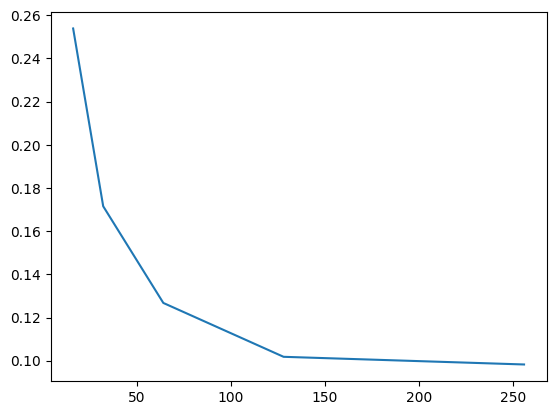

In [10]:
from matplotlib import pyplot as plt
plt.plot(np.array(list(acc_dict.keys())), 1-np.array(list(acc_dict.values())))

In [11]:
model.sampler

'ancestral'